### Standard Metrics for Multi-Target, multi-label classification.

#### Goal: Look at standard classification metrics for the models so far.

The competition format for predictions is 104 columns of probabilities (float between 0 and 1) that one-hot encode each of 9 targets (each with its own labels).  

If we use flat_to_labels on the probability outputs of the classifiers to rebuild the original data format 9 columns of labels, we can use all the standard sklearn metrics (accuracy_score, f1_score, etc.) separately for each classifier and also compute an aggregate score for all 9 colums.

There is another issue however for metrics (such as log_loss) that use probability predictions.  As previously described, the probability output of the OneVsRest classifier is not normalized.  So to use sklearn.metrics.log_loss (and like tools), we need to perform that normalization before handing off to the metric.  Note that normalized probability predictions are in the flattened shape, n_samples by 104 (n_samples by num_targets * num_labels/target).

This piece-wise approach to measurement will give us much more insight into the performance of the combined classifier than the log loss aggregate.  We can compute an aggregate score as well and compare to the competition metric and scores.

##### Important note: see flat_to_labels.ipynb and mod0_multiple_ways_v2.ipynb for rationale and background.

##### We're using the term "unflattened" to refer to predictions that are in the format of the original data (i.e. 9 targets, all multilabel).

#### Goal: summarize performance of all the classifiers in first_models.

We have 9 targets with as many as 37 labels and as few as 3 labels.  That's a lot of information to take in.  For a performance summary, we begin with plotting accuracy as a bar plot for all the classifiers.

Raw model outputs and ys are in ./fmm/*

#### Workflow:

* Pull raw model (train/test) outputs and y values from files saved by first_models_metrics (mod0, mod1, mod2, mod3, mod4).
* Construct the unflattened versions and save (m0, m1, m2, m3, m4).
* Build a function to run value-based (accuracy, F1, classification_resport, etc.) metrics and display outputs for each target in the predictions.
* Show results for accuracy and F1
* Build a function to properly normalize raw probability outputsand display probability-based (log loss, ROC AUC) metrics.
* Show results for log loss and ROC AUC
* Demonstrate use of standard metrics on individual target outputs in a model

### Preliminaries

In [1]:
import os

# ignore warnings in sklearn
import warnings
warnings.filterwarnings("ignore")

In [2]:
### in case I change anything under the covers, make it show up here.
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
pd.set_option('display.max_columns', 60)

from timeit import default_timer as timer

# Import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
# metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss

# pipelines
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, label_binarize

# in .python directory

### split ensuring train/test both have all labels
from python.multilabel import multilabel_train_test_split
### drivendata metric
from python.dd_mmll import multi_multi_log_loss, BOX_PLOTS_COLUMN_INDICES

In [3]:
from sklearn.metrics import confusion_matrix

def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

## first generate with specified labels
# labels = [ ... ]
# cm = confusion_matrix(ypred, y, labels)

# # then print it in a pretty way
# print_cm(cm, labels)

In [4]:
from python.plot_confusion_matrix import plot_confusion_matrix as plot_cm

### Load up all the raw model outputs into a dictionary for each one.

In [5]:
# names of the raw model outputs
model_names = ['mod0', 'mod1', 'mod2', 'mod3', 'mod4']

In [6]:
# extensions for the files
model_extensions = ['_test_probas.npy',  '_train_probas.npy', '_y_test.npy',  '_y_train.npy']

In [7]:
# names for the directory keys
model_outs = [s[1:-4] for s in model_extensions]

In [8]:
# check the file name prefixes, the suffixes, and the va
model_names, model_extensions, model_outs

(['mod0', 'mod1', 'mod2', 'mod3', 'mod4'],
 ['_test_probas.npy', '_train_probas.npy', '_y_test.npy', '_y_train.npy'],
 ['test_probas', 'train_probas', 'y_test', 'y_train'])

##### make some empty dictionaries named by the models

In [9]:
# this does this for each model: 'mod0 = dict()''
for mod_name in model_names:
    exec('{} = dict()'.format(mod_name))

##### load up the dictionaries with the data from the output files

In [10]:
# this does "mod0['test_probas'] = np.load('fmm_out/mod0_test_probas.npy') for all the (4) files for each model(5)
for m_name in model_names:
    for m_ext, m_key in zip(model_extensions, model_outs):
        exec("{}['{}'] = np.load('fmm_out/{}{}')".format(m_name, m_key, m_name, m_ext))

In [11]:
# check that the keys showed up correctly
mod0.keys()

dict_keys(['test_probas', 'train_probas', 'y_test', 'y_train'])

In [12]:
# check that the data showed up correctly and that it's named correctly
mod4['train_probas'].shape, mod4['test_probas'].shape, mod4['y_train'].shape, mod4['y_test'].shape

((320222, 104), (80055, 104), (320222, 104), (80055, 104))

#### Model raw probability outputs and ys are now in dictionaries.  Add the multi-target, multi-label versions of the data (i.e. the unflattened outputs - looks like the original input data).

Build the __*(9 targets, n_labels(target))*__ version (dataframe) of each output and y so we can run standard metrics.

For each model, compute a metric (accuracy, say) capture the results and plot as a bar graph (each bar should have two parts, train and test, with different colors).

In [13]:
# get the unflattener...
import python.flat_to_labels

In [14]:
# use this name without prefix
from python.flat_to_labels import flat_to_labels

In [15]:
# also these names
LABELS = python.flat_to_labels.LABELS
BPCI = python.flat_to_labels.BPCI
the_labels = python.flat_to_labels.the_labels

In [16]:
mod0.keys()

dict_keys(['test_probas', 'train_probas', 'y_test', 'y_train'])

##### mod0 through mod4 all have the keys ['test_probas', 'train_probas', 'y_test', 'y_train'].  When this function gets done, the output dictionaries should have the keys ['test_yhat', 'train_yhat', 'y_test', 'y_train'.

In [17]:
list(zip(['test_probas', 'train_probas', 'y_test', 'y_train'], ['test_yhat', 'train_yhat', 'y_test', 'y_train']))

[('test_probas', 'test_yhat'),
 ('train_probas', 'train_yhat'),
 ('y_test', 'y_test'),
 ('y_train', 'y_train')]

In [18]:
def build_unflattened_version(mod):                           
    ''' takes a dictionary with flat predictions or y data and computes the unflattened versions.
        returns a new dictionary with hierarchical versions (as dataframes).    '''
    key_mapping=dict([('test_probas', 'test_yhat'), ('train_probas', 'train_yhat'), 
                      ('y_test', 'y_test'), ('y_train', 'y_train')])                          
    return {key_mapping[k] : pd.DataFrame(data=flat_to_labels(mod[k]), index=None, columns=LABELS) for k in mod.keys()}

#####  Show us what exec is going to see, please.

In [19]:
for m_num in range(0, 5):
    print('m{} = build_unflattened_version(mod{})'.format(m_num, m_num))

m0 = build_unflattened_version(mod0)
m1 = build_unflattened_version(mod1)
m2 = build_unflattened_version(mod2)
m3 = build_unflattened_version(mod3)
m4 = build_unflattened_version(mod4)


In [20]:
for m_num in range(0, 5):
    exec('m{} = build_unflattened_version(mod{})'.format(m_num, m_num))

#### Check the output.

In [21]:
type(m0)

dict

In [22]:
m0.keys()

dict_keys(['test_yhat', 'train_yhat', 'y_test', 'y_train'])

In [23]:
m0['test_yhat'].shape

(80055, 9)

In [24]:
type(m0['test_yhat'])

pandas.core.frame.DataFrame

In [25]:
m0['test_yhat'].head()

,Function,Object_Type,Operating_Status,Position_Type,Pre_K,Reporting,Sharing,Student_Type,Use
0,NO_LABEL,Benefits,PreK-12 Operating,NO_LABEL,NO_LABEL,School,School Reported,Unspecified,Instruction
1,NO_LABEL,Benefits,PreK-12 Operating,NO_LABEL,NO_LABEL,School,School Reported,Unspecified,Instruction
2,NO_LABEL,Benefits,PreK-12 Operating,NO_LABEL,NO_LABEL,School,School Reported,Unspecified,Instruction
3,NO_LABEL,Benefits,PreK-12 Operating,NO_LABEL,NO_LABEL,School,School Reported,Unspecified,Instruction
4,Substitute Compensation,Benefits,PreK-12 Operating,Substitute,NO_LABEL,School,School Reported,Unspecified,Instruction


In [26]:
# these are the dictionaries containing unflattened predictions
the_cooked_models = [m0, m1, m2, m3, m4]

#### The unflattened versions of the outputs and ys are now in m0, m1, m2, m3, m4.

These outputs are predictions not probabilties.  Predictions are built by selecting most probable label within a target.  See flat_to_labels.ipynb for details.

### ===========================================================================

### Accuracy profile for all classifiers

#### First build a function that will do the plotting.

In [27]:
from sklearn.metrics import accuracy_score, f1_score

def plot_metric_profile(models, metric):
    ''' Takes list of dictionary containing value predictions from OneVsRest and 
        shows bar plots of train/test metrics for each target model.     
        Metric can be one of accuracy_score, fi_score.        '''   
    metric_names = {accuracy_score : 'Accuracy', f1_score : 'F1'}
    for num, model in enumerate(models):
        if metric == f1_score:
            train_scores = [metric(model['y_train'][name], model['train_yhat'][name], average='macro') for name in LABELS]
            test_scores =  [metric(model['y_test'][name],  model['test_yhat'][name], average='macro') for name in LABELS]
            test_mean = np.mean(test_scores)
            train_mean = np.mean(train_scores)
        elif metric == accuracy_score:
            train_scores = [metric(model['y_train'][name], model['train_yhat'][name]) for name in LABELS]
            test_scores =  [metric(model['y_test'][name],  model['test_yhat'][name]) for name in LABELS]
            test_mean = np.mean(test_scores)
            train_mean = np.mean(train_scores)
        else:
            return 'Bad metric: use accuracy_score or f1_score.'       

        # print results as well as plot
        print('test scores, model {}: {}'.format(num, test_scores))
        print('mean test score: {:0.4f}'.format(test_mean))
        print('mean train score: {:0.4f}\n'.format(train_mean))
        
        # x coordinates for the bars
        x_offsets = np.arange(0, 2 * len(LABELS), 2)
        
        fig, ax = plt.subplots(figsize=(5, 5))
        plt.bar(x_offsets,     train_scores, color='deeppink', label='train')
        plt.bar(x_offsets + 1, test_scores,  color='cornflowerblue',  label='test')   
        plt.plot([-1, 2 * len(LABELS)], [test_mean, test_mean], color='darkorange', label='all labels test mean')
        plt.xticks(x_offsets, LABELS, rotation=60)
        plt.title('{} by target for model {}, mean test score: {:0.3}'.format(metric_names[metric], num, test_mean))
        plt.legend(bbox_to_anchor=(1.04,1), loc="upper left");

#### Plot

In [28]:
type(the_cooked_models); [type(x) for x in the_cooked_models]

[dict, dict, dict, dict, dict]

test scores, model 0: [0.2759602773093498, 0.4252951096121417, 0.8587970770095559, 0.3729061270376616, 0.7663231528324277, 0.6409843232777466, 0.633651864343264, 0.5570420336018987, 0.5082131034913497]
mean test score: 0.5599
mean train score: 0.5609

test scores, model 1: [0.7976016488664044, 0.8729623383923553, 0.9356567359940041, 0.8419461620136156, 0.9528823933545687, 0.8650677659109363, 0.8145649865717319, 0.8728873899194304, 0.8034851039910061]
mean test score: 0.8619
mean train score: 0.8619

test scores, model 2: [0.9530572731247268, 0.9806383111610768, 0.98438573480732, 0.9781275373180938, 0.9896696021485228, 0.9777652863656237, 0.9704578102554494, 0.9789144962838049, 0.9679720192367747]
mean test score: 0.9757
mean train score: 0.9979

test scores, model 3: [0.818299918805821, 0.9022671913059771, 0.9517331834363875, 0.8656923365186434, 0.9679345450003123, 0.8847542314658672, 0.8617325588657798, 0.8983823621260384, 0.8511023671226032]
mean test score: 0.8891
mean train score: 

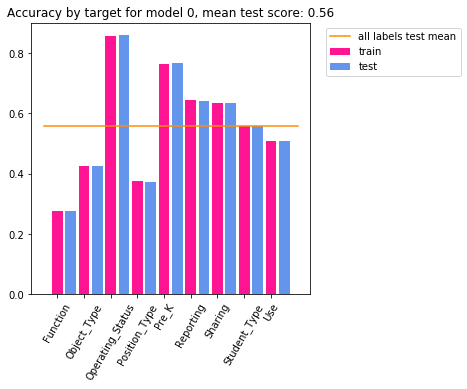

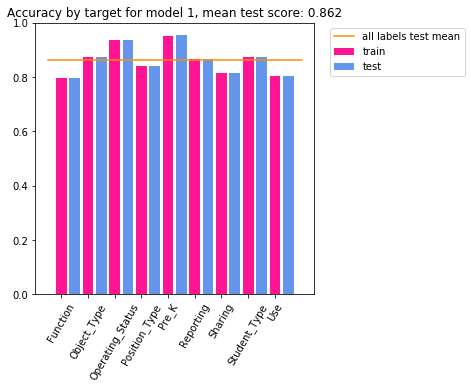

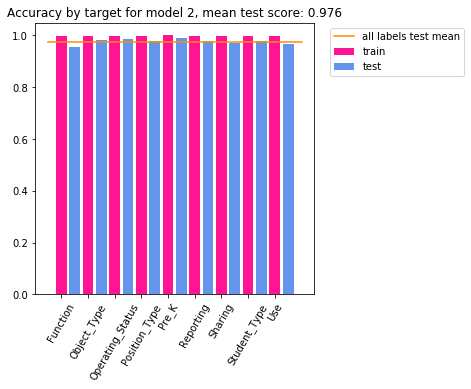

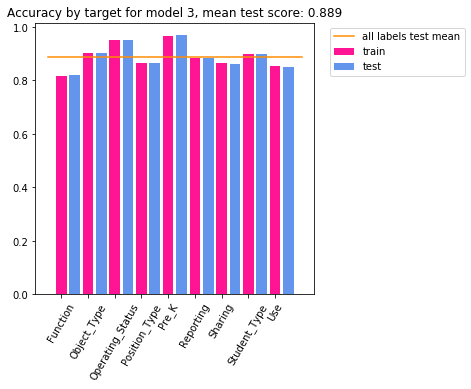

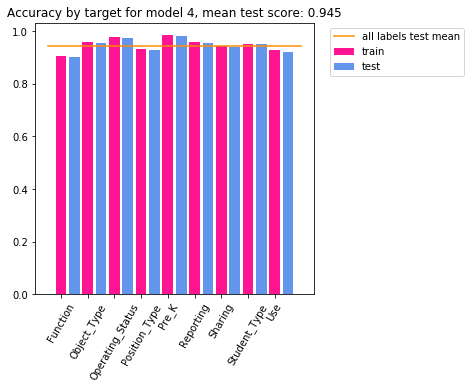

In [29]:
plot_metric_profile(the_cooked_models, accuracy_score)

### F1 profile for all classifiers

In [30]:
### this is a hack to suppress F1 warnings about labels without any predictions; it's fine that it gives me a zero.
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

test scores, model 0: [0.031213026568557338, 0.11828252992097775, 0.308287152329098, 0.05122815150467009, 0.2892347875693349, 0.26109982606789833, 0.15544687755489528, 0.07980403119750748, 0.08445490568926393]
mean test score: 0.1532
mean train score: 0.1533

test scores, model 1: [0.6863955183443519, 0.801034354680879, 0.796840957349409, 0.8096589149235828, 0.8643658508881802, 0.8225180473170447, 0.624307868730386, 0.6999880443875448, 0.6411074364746858]
mean test score: 0.7496
mean train score: 0.7513

test scores, model 2: [0.8629692075236156, 0.9559772750410257, 0.9210301866625641, 0.9471714259338578, 0.9673628943929405, 0.9686679986784695, 0.9485787238988822, 0.9412111840578974, 0.8836772001360665]
mean test score: 0.9330
mean train score: 0.9952

test scores, model 3: [0.6427788684372983, 0.7702847586218684, 0.8456214461496708, 0.768337470946086, 0.9073450934902909, 0.8448795807358002, 0.7455284241108686, 0.7692047947995205, 0.665967623250046]
mean test score: 0.7733
mean train s

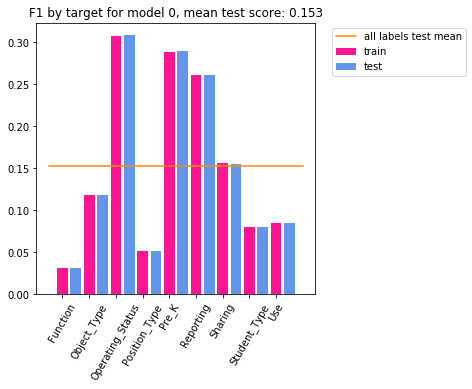

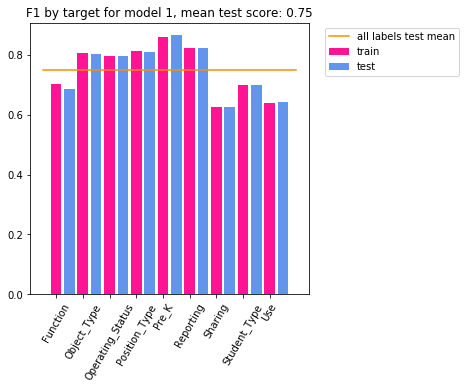

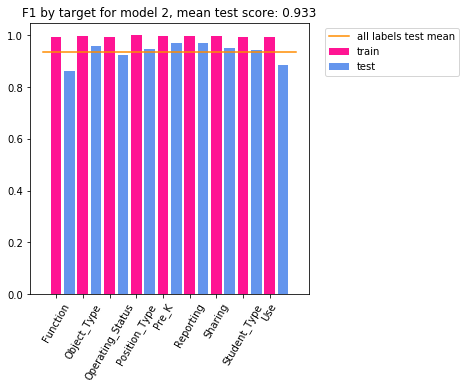

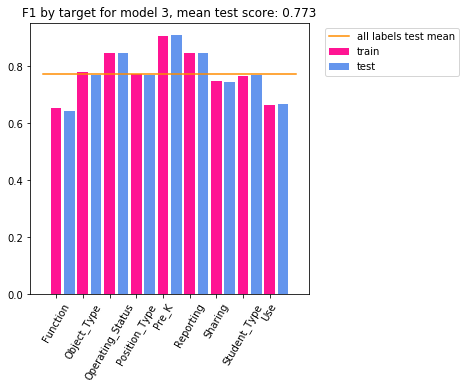

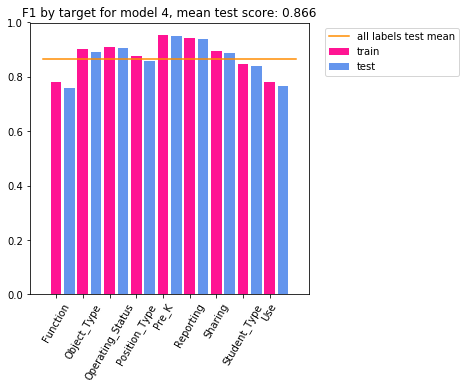

In [31]:
plot_metric_profile(the_cooked_models, f1_score)

### Log loss profile for all classifiers

As mentioned above, log loss uses the probabilty output of the classifier.  Before we can use it we need to normalize within target columns such that for each target, the sum of probabilities for each row is 1.

In [32]:
print(LABELS); print(BPCI)

['Function', 'Object_Type', 'Operating_Status', 'Position_Type', 'Pre_K', 'Reporting', 'Sharing', 'Student_Type', 'Use']
[slice(0, 37, None), slice(37, 48, None), slice(48, 51, None), slice(51, 76, None), slice(76, 79, None), slice(79, 82, None), slice(82, 87, None), slice(87, 96, None), slice(96, 104, None)]


In [33]:
# LABELS = ['Function', 'Object_Type','Operating_Status', 'Position_Type', 'Pre_K', 
#           'Reporting','Sharing', 'Student_Type','Use']
# BPCI is the slices that get the columns associated with LABELS, i.e.
#          [slice(0, 37, None), slice(37, 48, None), slice(48, 51, None), slice(51, 76, None), slice(76, 79, None), 
#           slice(79, 82, None), slice(82, 87, None), slice(87, 96, None), slice(96, 104, None)]

def norm_probs(probs, indices=BPCI, targets = LABELS):
    ''' input:  array n_samples, 104
        output: array n_samples, 104 normalized within target columns such that for each target,
                                       the sum of probabilities for each row is 1'''
    # make a copy; don't want to smash the input
    lprobs = np.copy(probs)
    for i, targ in enumerate(targets):
        # grab the columns for each target - that's in BPCI indexed by position in LABELS
        # don't need a varible: probs[indices[i]] = probs[indices[i]]
        # normalize so probabilities sum to one (unless sum is zero, then we clip)
        lprobs[:, indices[i]] /=  np.clip(np.sum(lprobs[:, indices[i]], axis=1, keepdims=True), 1e-15, np.inf)

    return lprobs

#### Test the function by looking at before and after.

#### Look at the unnormalized probability row sums
All 104 columns predicted indepently means any number of 1 predictions is fine.

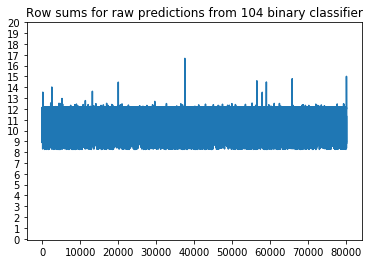

In [34]:
plt.plot(np.sum(mod0['test_probas'], axis=1))
#plt.plot(np.sum(mod0['test_probas'][:, 0:37], axis=1));
#plt.ylim(-0.1, 5)
plt.yticks(range(0,21))
plt.ylim(-0.1, 20)
plt.title('Row sums for raw predictions from 104 binary classifier');

In [35]:
my_probs = norm_probs(mod0['test_probas'])

#### After normalization all rows sum to 9 (1 each for 9 targets).

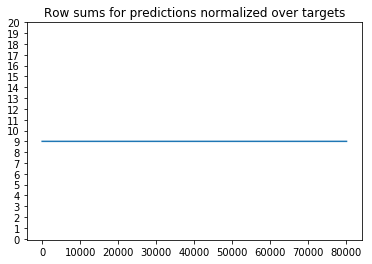

In [36]:
plt.plot(np.sum(my_probs, axis=1))
# plt.plot(np.sum(my_probs[:, 0:37], axis=1, keepdims=True));
plt.yticks(range(0,21))
plt.ylim(-0.1, 20)
plt.title('Row sums for predictions normalized over targets');

#### =============================================================================

### Metrics reporting for probability-based metrics

In [37]:
# LABELS = ['Function', 'Object_Type','Operating_Status', 'Position_Type', 'Pre_K', 
#           'Reporting','Sharing', 'Student_Type','Use']
# BPCI is the slices that get the columns associated with LABELS, i.e.
#          [slice(0, 37, None), slice(37, 48, None), slice(48, 51, None), slice(51, 76, None), slice(76, 79, None), 
#           slice(79, 82, None), slice(82, 87, None), slice(87, 96, None), slice(96, 104, None)]

from sklearn.metrics import log_loss, roc_auc_score
def plot_proba_metric_profile(models, metric=log_loss):
    ''' Takes list of dictionary containing probabilty predictions from OneVsRest, normalizes and 
        shows bar plots of train/test metrics for each target models.
        metric can be one of accuracy_score, fi_score.
        Input: list of dictionaries with raw probabilityoutputs and values from OneVsRest() clf.  '''
    
    metric_names = {log_loss : 'Log loss', roc_auc_score: 'ROC AUC'}
    for num, model in enumerate(models):
        if metric in [log_loss, roc_auc_score]:
        # note: BPCI[idx] is the slice that gets the right columns for each target
            normed_train_probas = norm_probs(model['train_probas'])
            train_scores = [metric(model['y_train'][:, BPCI[idx]], 
                                   normed_train_probas[:, BPCI[idx]]) 
                            for (idx, name) in enumerate(LABELS)]
            normed_test_probas = norm_probs(model['test_probas'])
            test_scores =  [metric(model['y_test'][:, BPCI[idx]],  
                                   normed_test_probas[:, BPCI[idx]]) 
                            for (idx, name) in enumerate(LABELS)]
            test_mean = np.mean(test_scores)
            train_mean = np.mean(train_scores)
        
        else:
            return 'Bad metric: use log_loss or roc_auc_score.'       
        # x coordinates for the bars
        x_offsets = np.arange(0, 2 * len(LABELS), 2)
        
        fig, ax = plt.subplots(figsize=(5, 5))
        plt.bar(x_offsets,     train_scores, color='deeppink', label='train')
        plt.bar(x_offsets + 1, test_scores,  color='cornflowerblue',  label='test')   
        plt.plot([-1, 2 * len(LABELS)], [test_mean, test_mean], color='darkorange', label='all labels test mean')
        plt.xticks(x_offsets, LABELS, rotation=60)
        plt.title('{} by target for model {}, mean test score: {:0.3}'.format(metric_names[metric], num, test_mean))
        plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
        
        print('test scores, model {}: {}'.format(num, test_scores))
        print('mean test score: {:0.4f}'.format(test_mean))
        print('mean train score: {:0.4f}\n'.format(train_mean))
        

####  Log loss profiles (note: 0 <= log loss, 0 is optimal).  The mean log loss over all targets matches DrivenData's custom metric value very closely.

test scores, model 0: [2.5993640833331293, 1.7790713782773349, 0.43724917637856714, 2.076740684977224, 0.6170593307114001, 0.8652013753930435, 1.1127088497348605, 1.2525358522714027, 1.4616233121847497]
mean test score: 1.3557
mean train score: 1.3535

test scores, model 1: [0.9227216537428532, 0.563952938524672, 0.19924110101036835, 0.6877115011519926, 0.16324890790239585, 0.4118984338890376, 0.5940658405161751, 0.4565722245982179, 0.6062364696680944]
mean test score: 0.5117
mean train score: 0.5110

test scores, model 2: [0.6478809073675881, 0.21601906894540834, 0.17984467282219815, 0.24397886291383092, 0.10697227841342793, 0.2619957415068749, 0.33487452914850563, 0.23235891145417195, 0.3644618689484351]
mean test score: 0.2876
mean train score: 0.0165

test scores, model 3: [0.6512978260289934, 0.3326064590223759, 0.14643155191061502, 0.46245183029396, 0.09748919147495469, 0.3172963810408245, 0.4187894096162697, 0.3194396862970004, 0.4688773408676897]
mean test score: 0.3572
mean tr

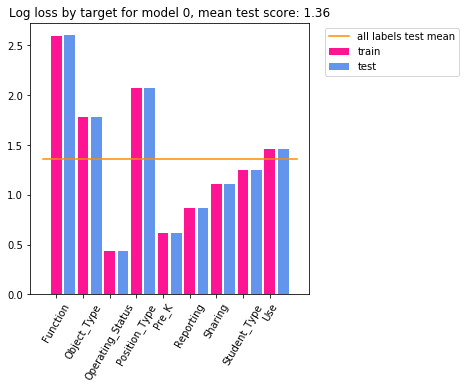

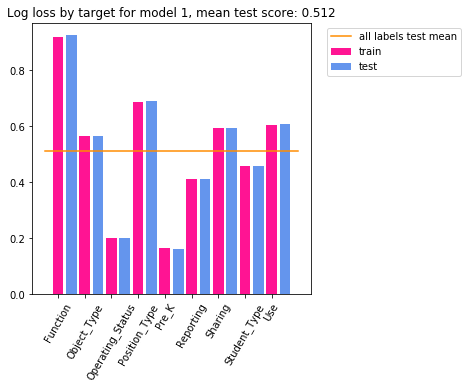

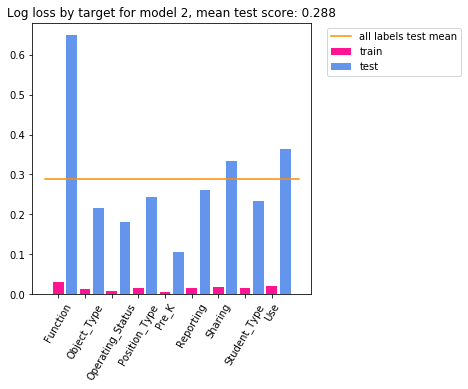

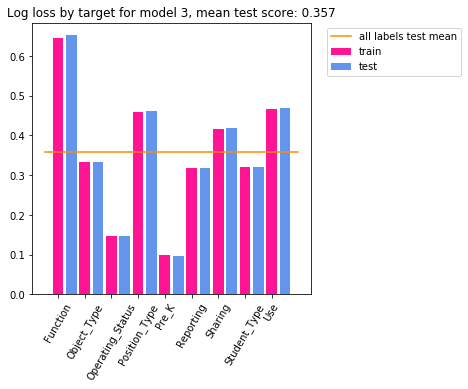

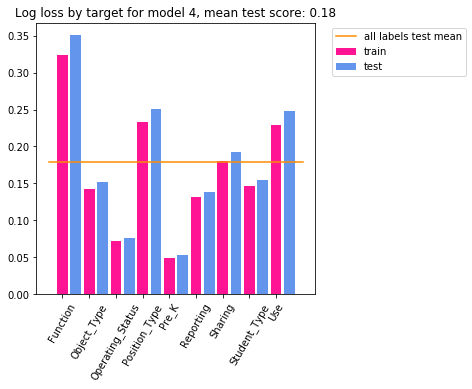

In [38]:
# get log loss scores from raw model ouputs 
plot_proba_metric_profile([mod0, mod1, mod2, mod3, mod4])

#### ROC AUC profiles (note: 0 <= ROC AUC <= 1, 1 is optimal)

test scores, model 0: [0.566461537836329, 0.6973986561799322, 0.5666132812715773, 0.6145820406904422, 0.5725614517987222, 0.5592113484454835, 0.5063725134590193, 0.5217761654008716, 0.47522176967613516]
mean test score: 0.5645
mean train score: 0.5671

test scores, model 1: [0.9811854016261803, 0.9849274244554088, 0.9560422177469707, 0.9866338431012882, 0.9785366412725874, 0.9439191425205854, 0.9213902079918664, 0.9713152185420424, 0.9633630033816138]
mean test score: 0.9653
mean train score: 0.9651

test scores, model 2: [0.9695842705694427, 0.9946475214389892, 0.9703155621882865, 0.9905509098948858, 0.9896005914029256, 0.990824916124295, 0.9896820082262717, 0.9828786041942935, 0.9765421100393104]
mean test score: 0.9838
mean train score: 1.0000

test scores, model 3: [0.9795903200679348, 0.9875025874141851, 0.9742428464497476, 0.9863322532585567, 0.9884648902753375, 0.9628459890318065, 0.9586882634275536, 0.9803029307237696, 0.965564062403379]
mean test score: 0.9759
mean train score

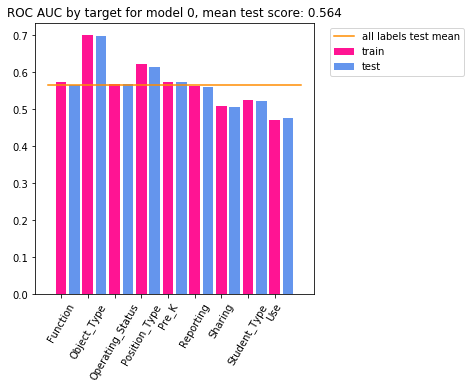

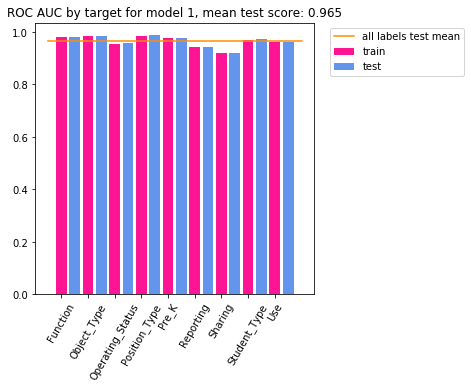

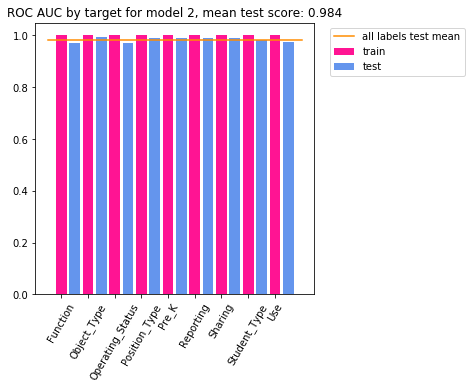

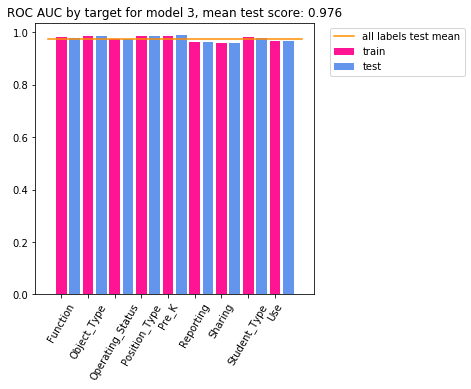

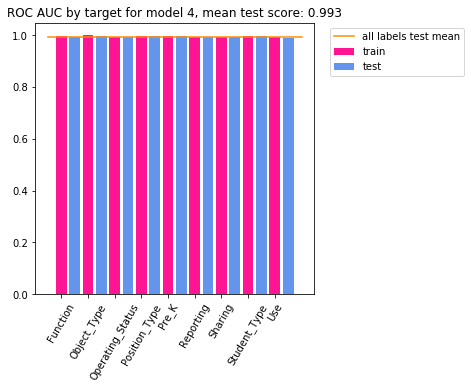

In [39]:
# get ROC AUC scores from raw model ouputs 
plot_proba_metric_profile([mod0, mod1, mod2, mod3, mod4], roc_auc_score)

#### =============================================================================

### Demonstrate standard sklearn metrics on unflattened model outputs

#### Start with training set

##### Build the predictions as 9 columns of labels

In [40]:
m0.keys()

dict_keys(['test_yhat', 'train_yhat', 'y_test', 'y_train'])

In [41]:
m0['train_yhat'].head()

,Function,Object_Type,Operating_Status,Position_Type,Pre_K,Reporting,Sharing,Student_Type,Use
0,Teacher Compensation,Base Salary/Compensation,PreK-12 Operating,Teacher,NO_LABEL,School,School Reported,Unspecified,Instruction
1,Teacher Compensation,Base Salary/Compensation,PreK-12 Operating,Teacher,NO_LABEL,School,School Reported,Unspecified,Instruction
2,NO_LABEL,Benefits,PreK-12 Operating,NO_LABEL,NO_LABEL,School,School Reported,Unspecified,Instruction
3,NO_LABEL,Benefits,PreK-12 Operating,NO_LABEL,NO_LABEL,School,School Reported,Unspecified,Instruction
4,NO_LABEL,Benefits,PreK-12 Operating,NO_LABEL,NO_LABEL,School,School Reported,Unspecified,Instruction


In [42]:
m0['y_train'].head()

,Function,Object_Type,Operating_Status,Position_Type,Pre_K,Reporting,Sharing,Student_Type,Use
0,Teacher Compensation,NO_LABEL,PreK-12 Operating,Teacher,NO_LABEL,School,School Reported,NO_LABEL,Instruction
1,Teacher Compensation,Base Salary/Compensation,PreK-12 Operating,Teacher,Non PreK,School,School Reported,Unspecified,Instruction
2,Substitute Compensation,Substitute Compensation,PreK-12 Operating,Teacher,NO_LABEL,School,School Reported,Unspecified,Instruction
3,Facilities & Maintenance,Benefits,PreK-12 Operating,Custodian,NO_LABEL,School,School Reported,Unspecified,O&M
4,Instructional Materials & Supplies,Supplies/Materials,PreK-12 Operating,Non-Position,NO_LABEL,School,School Reported,Special Education,Instruction


#### Because the unflattened, corrected prediction are cast to dataframes, accessing the targets is straightforward.

In [43]:
for name in LABELS: 
    score = accuracy_score(m0['y_train'][name], m0['train_yhat'][name])
    print('Accuracy for {}: {:0.4f}'.format(name, score))

Accuracy for Function: 0.2775
Accuracy for Object_Type: 0.4259
Accuracy for Operating_Status: 0.8583
Accuracy for Position_Type: 0.3746
Accuracy for Pre_K: 0.7653
Accuracy for Reporting: 0.6433
Accuracy for Sharing: 0.6363
Accuracy for Student_Type: 0.5575
Accuracy for Use: 0.5090


In [44]:
the_labels['Operating_Status']

array(['Non-Operating', 'Operating, Not PreK-12', 'PreK-12 Operating'],
      dtype='<U22')

#### The confusion matrix for a target

In [45]:
OpStatCM = confusion_matrix(m0['y_train']['Operating_Status'], m0['train_yhat']['Operating_Status'],
                            labels=the_labels['Operating_Status'])
print_cm(OpStatCM, labels=the_labels['Operating_Status'])

                                    Non-Operating Operating, Not PreK-12      PreK-12 Operating 
             Non-Operating                   13.0                    0.0                38389.0 
    Operating, Not PreK-12                    2.0                    0.0                 6987.0 
         PreK-12 Operating                    1.0                    0.0               274830.0 


#### Plot the confusion matrix with a heatmap

Confusion matrix, without normalization
[[    13      0  38389]
 [     2      0   6987]
 [     1      0 274830]]


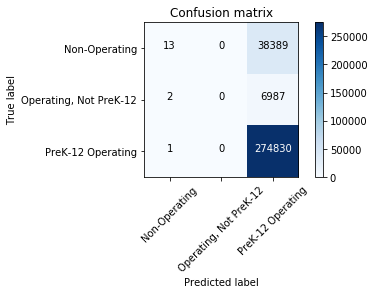

In [46]:
plot_cm(OpStatCM, the_labels['Operating_Status'], normalize=False)

#### The classification report displays precision, recall and F1 score for each label in a target.

In [47]:
for name in LABELS: 
    print('========== Classification report for {} =========='.format(name))
    print(classification_report(m4['y_test'][name], m4['test_yhat'][name]))
    print()

========== Classification report for Function ==========
                                                 precision    recall  f1-score   support

                             Aides Compensation       0.95      0.91      0.93      3981
                   Career & Academic Counseling       0.86      0.59      0.70       567
                                 Communications       0.91      0.65      0.76        63
                         Curriculum Development       0.85      0.75      0.80      1547
         Data Processing & Information Services       0.60      0.48      0.54       599
                      Development & Fundraising       0.75      0.17      0.27        18
                                     Enrichment       0.81      0.82      0.81      2093
                       Extended Time & Tutoring       0.79      0.62      0.70      1688
                       Facilities & Maintenance       0.93      0.93      0.93      4029
                            Facilities Planning     

                             precision    recall  f1-score   support

          Business Services       0.76      0.58      0.66      1169
                       ISPD       0.85      0.73      0.79      5158
                Instruction       0.92      0.98      0.95     40671
                 Leadership       0.91      0.75      0.83      3237
                   NO_LABEL       0.93      0.92      0.93     15699
                        O&M       0.96      0.96      0.96      9296
Pupil Services & Enrichment       0.92      0.76      0.83      4737
 Untracked Budget Set-Aside       0.90      0.10      0.18        88

                avg / total       0.92      0.92      0.92     80055




#### ===================================================================================================